<a href="https://colab.research.google.com/github/dmunger27/dental-xray-segmentation/blob/main/Data_Preprocessing_and_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing and Exploration


*   [Pull in Images from S3](#pull)
*   [Display Images with and Without Masks](#display)
*   [EDA and Preprocessing](#preprocess)



<a name="pull"></a>
## Pull in Images from S3

In [ ]:
#!pip install cloudpathlib
#!pip install boto3
#!pip install pillow
#!pip install opencv-python

In [12]:
import os
import pandas as pd
import numpy as np
from cloudpathlib import CloudPath
from cloudpathlib import S3Client
import matplotlib.pyplot as plt
import boto3
import glob
import random
import re
import PIL
import keras

In [4]:
# Set environment variables
key_data = pd.read_csv('rootkey.csv')
#os.environ['AWS_ACCESS_KEY'] = ''
#os.environ['AWS_SECRET_KEY'] = ''

In [5]:
# Create files in local storage for x-ray data

def gatherS3Data(s3_path, folder_name):
  s3_client = S3Client(aws_access_key_id=os.getenv('AWS_ACCESS_KEY'), aws_secret_access_key=os.getenv('AWS_SECRET_KEY'))
  x_rays_images = s3_client.CloudPath(s3_path)
  x_rays_images.download_to(folder_name)

gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/mask/', 'abnormality_masks')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/Radiographs/', 'original_images')
gatherS3Data('s3://ads-599-capstone-data/ads-599-team7/teeth_mask/', 'teeth_masks')

<a name="display"></a>
## Display Images with and Without Masks

In [6]:
# Make a list of all original image files
def image_to_plot(images, cmap):
  file_list = images
  image_list = [plt.imread(i) for i in file_list]
  # Display 4 original x_ray images in grayscale
  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  k=0
  for i in range(2):
    for j in range(2):
      axes[i,j].imshow(image_list[k], cmap=cmap, aspect='auto')
      k+=1
  plt.show()

In [7]:
random.seed(27)
# Create list of filenames for original radiographs
originals = sorted(glob.glob('original_images/*'))
# Take a random sample of 4 images
sample_originals = random.sample(originals, 4)
# Print filenames
print(sample_originals)
# Extract only the filename
filenames = [re.search(r'(?<=/).*',i).group() for i in sample_originals]
# Make list for teeth masks and abnormality masks
abnormalities = ['abnormality_masks/'+ i for i in filenames]
teeth = ['teeth_masks/' + i.lower() for i in filenames]

['original_images/682.JPG', 'original_images/521.JPG', 'original_images/734.JPG', 'original_images/328.JPG']


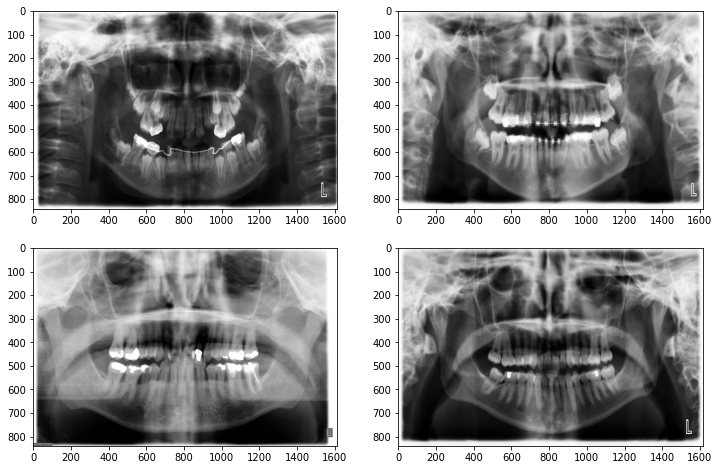

In [8]:
# Display original radiographs
image_to_plot(sample_originals, 'gray')

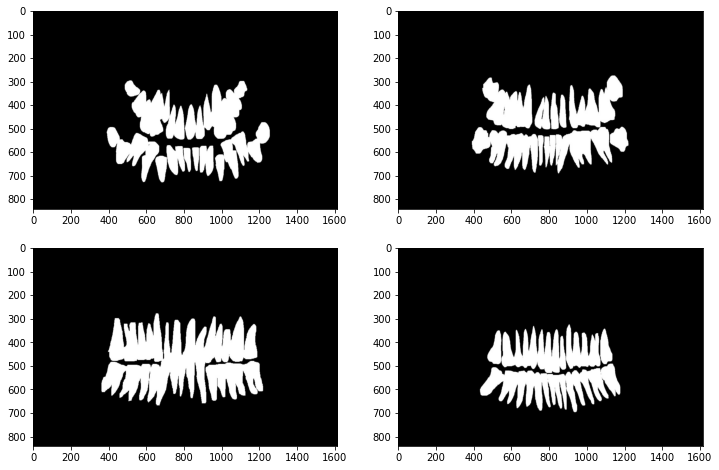

In [9]:
# Display 4 teeth mask images (just the annotations)
image_to_plot(teeth, 'gray')

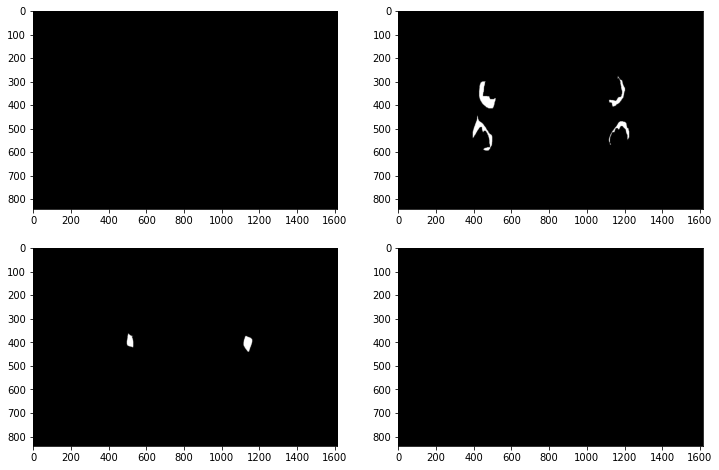

In [98]:
# Display 4 abnormality mask images (just the annotations)
image_to_plot(abnormalities, 'gray')
# Note that some radiographs have no abnormalities

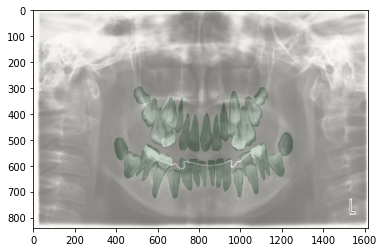

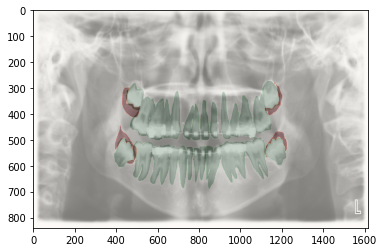

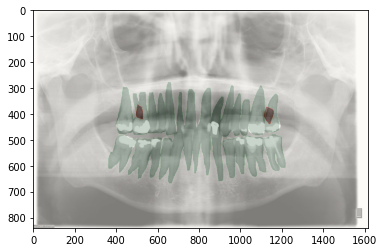

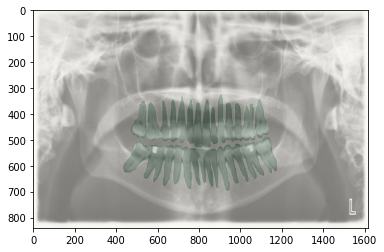

In [105]:
# Overlay masks over original image
def mask_with_image(image, mask1, mask2):
  files = [image, mask1, mask2]
  images = [plt.imread(i)[:,:,0] if plt.imread(i).ndim == 3 else plt.imread(i) for i in files]
  colors = ['gray', 'Greens', 'Reds']
  alpha = [1, 0.3, 0.3]
  for i in range(len(files)):
    plt.imshow(images[i], cmap=colors[i], alpha=alpha[i], aspect='auto')
  plt.show()

for i in range(len(teeth)):
  mask_with_image(sample_originals[i], teeth[i], abnormalities[i])


<a name="preprocess"></a>
## EDA and Preprocessing

In [26]:
# Create lists for teeth and abnormality masks
abnormalities = sorted(glob.glob('abnormality_masks/*'))
teeth = sorted(glob.glob('teeth_masks/*'))

# Get all the image details for the original images and store in a dataframe
def image_info(image_list):
  imgs = [PIL.Image.open(i) for i in image_list]
  file_type = [i.format for i in imgs]
  file_size = [i.size for i in imgs]
  file_colors = [i.mode for i in imgs]
  # Convert to numpy array and take the sum of the array to determine if the image is blank
  file_nparray_sums = [np.sum(np.asarray(i)) for i in imgs]
  image_df = pd.DataFrame({'type': file_type, 'size': file_size, 
                          'colors': file_colors, 'np_sums': file_nparray_sums})
  return image_df
# Create df for each folder to further analyze the images
original_df = image_info(originals)
abnormality_df = image_info(abnormalities)
teeth_df = image_info(teeth)

In [44]:
# Summarize info from each df
def summary_statistics(df, df_name):
  print(f"The summary statistics for {df_name} are")
  print({'type_values': df['type'].unique(), 'size_values': df['size'].unique(), 'color_values': df['colors'].unique()})
print(summary_statistics(original_df, 'Radiographs'))
print(summary_statistics(abnormality_df, 'Abnormalities'))
print(summary_statistics(teeth_df, 'Teeth'))

The summary statistics for Radiographs are
{'type_values': array(['JPEG'], dtype=object), 'size_values': array([(1615, 840)], dtype=object), 'color_values': array(['RGB'], dtype=object)}
None
The summary statistics for Abnormalities are
{'type_values': array(['JPEG'], dtype=object), 'size_values': array([(1615, 840)], dtype=object), 'color_values': array(['L'], dtype=object)}
None
The summary statistics for Teeth are
{'type_values': array(['JPEG'], dtype=object), 'size_values': array([(1615, 840)], dtype=object), 'color_values': array(['RGB'], dtype=object)}
None


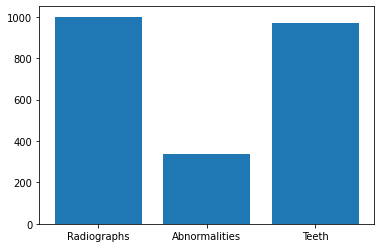

In [46]:
# Compare count of images that are not blank
df_names = ['Radiographs', 'Abnormalities', 'Teeth']
df_counts = [np.count_nonzero(original_df['np_sums']), np.count_nonzero(abnormality_df['np_sums']), np.count_nonzero(teeth_df['np_sums'])]
plt.bar(df_names, df_counts)
plt.show()
# Only a little under 400 images actually have abnormalities to train on

In [47]:
# Resize all images to 256x256
def resize_images(image_list):
  imgs = [PIL.Image.open(i) for i in image_list]
  new_imgs = [i.resize((256, 256)) for i in imgs]
  return new_imgs
# Apply resize function
resized_original = resize_images(originals)
resized_abnormalities = resize_images(abnormalities)
resized_teeth = resize_images(teeth)

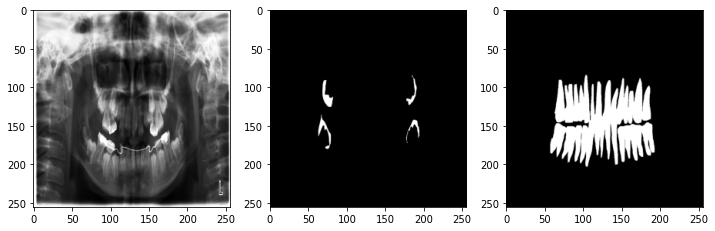

In [66]:
random.seed(27)
# Print sample of resized images
fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].imshow(random.sample(resized_original, 1)[0], cmap='gray')
axes[1].imshow(random.sample(resized_abnormalities, 1)[0], cmap='gray')
axes[2].imshow(random.sample(resized_teeth, 1)[0], cmap='gray')